In [42]:
import math
import rebound
import numpy as np
import matplotlib.pyplot as plt
import collresolve

In [89]:
def setupSimulation():
    ''' Setup the 3-Body scenario'''
    sim = rebound.Simulation()
    sim.units = ('yr2pi', 'AU', 'Msun')
    sim.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    sim.add(m=1.)
    sim.add(m=3e-7, x = 1, y = 0, z=0, vx = 0, vy =1, vz = 0)
    sim.add(m=1e-7, x = 1.0001, y = .00001, z=0, vx = -1.000005, vy =1.03, vz = 0)
    # sim.add(m=5e-5, a=1.5, e = 0.3, omega = np.pi)
    ps = sim.particles
    for i, r in enumerate([7e8, 7e6, 4.85e6]):
        ps[i].r = r # we now set collision radii!
    sim.convert_particle_units('s', 'm', 'kg')
    sim.move_to_com()
    return sim, ps


In [90]:
tmax = 1000

700000000.0
7000000.0
4850000.0
Particles in the simulation at t=   0.0: 3
System Mass: [1.9884754159665356e+30, 5.965426247899606e+23, 1.9884754159665355e+23]
Particles in the simulation at t=1000.0: 2
System Mass: [1.9884754159665356e+30, 7.953901663866142e+23]


Text(0.5, 1.0, 'T+ 3.2e-05 Years')

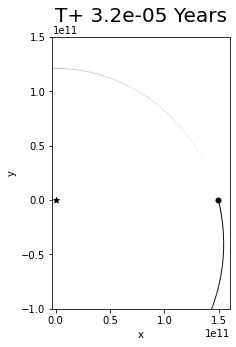

In [91]:
sim, ps = setupSimulation()
for p in ps:
    print(p.r)
sim.collision = "direct"
sim.collision_resolve = "merge" # Built in function

print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
print("System Mass: {}".format([p.m for p in sim.particles]))
sim.integrate(tmax)
print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
print("System Mass: {}".format([p.m for p in sim.particles]))
rebound.OrbitPlot(sim, lw = 1, xlim = (-3e9, 1.6e11), ylim = (-1.e11, 1.5e11))
plt.title('T+ {:.2} Years'.format(sim.t/3600/24/365.24), fontsize = 20, pad=15)

In [92]:
sum([9.942377079832678e+25, 1.988475415966536e+25]) == 1.1930852495799214e+26

True

In [93]:
def my_merge(sim_pointer, collided_particles_index):

    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.    
    j = collided_particles_index.p2 

    swap = False
    if j < i:
        i = collided_particles_index.p2
        j = collided_particles_index.p1
        swap = True

    # This part is exciting! We can execute additional code during collisions now!
    cx = (ps[i].x + ps[j].x)/2
    cy = (ps[i].y + ps[j].y)/2
    cr = (ps[i].r + ps[j].r)/2
    xlim = (cx-3*cr, cx+3*cr)
    ylim = (cy-3*cr, cy+3*cr)
    rebound.OrbitPlot(sim)
    fig, ax = rebound.OrbitPlot(sim, xlim = xlim, ylim = ylim)
    circle1 = plt.Circle((ps[i].x, ps[i].y), ps[i].r, color='r')
    circle2 = plt.Circle((ps[j].x, ps[j].y), ps[j].r, color='blue')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.set_title("Merging particle {} into {}".format(j, i))
    ax.text(ps[1].x, ps[1].y, "1"); 
    ax.text(ps[2].x, ps[2].y, "2")
    plt.title('T+ {:.2} Years'.format(sim.t/3600/24/365.24), fontsize = 20, pad=15)
    # So we plot the scenario exactly at the timestep that the collision function is triggered

    # Merging Logic 
    total_mass = ps[i].m + ps[j].m
    merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass # conservation of momentum

    # merged radius assuming a uniform density
    merged_radius = (ps[i].r**3 + ps[j].r**3)**(1/3)

    ps[i] = merged_planet   # update p1's state vector (mass and radius will need corrections)
    ps[i].m = total_mass    # update to total mass
    ps[i].r = merged_radius # update to joined radius

    return 1 if swap else 2

Particles in the simulation at t=   0.0: 3
System Mass: [1.9884754159665356e+30, 5.965426247899606e+23, 1.9884754159665355e+23]
Particles in the simulation at t=1000.0: 2
System Mass: [1.9884754159665356e+30, 7.953901663866142e+23]


Text(0.5, 1.0, 'T+ 3.2e-05 Years')

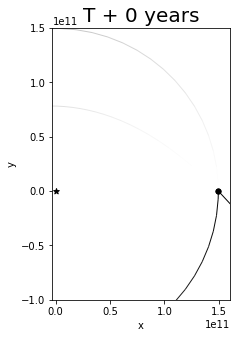

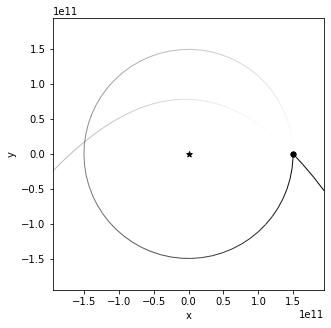

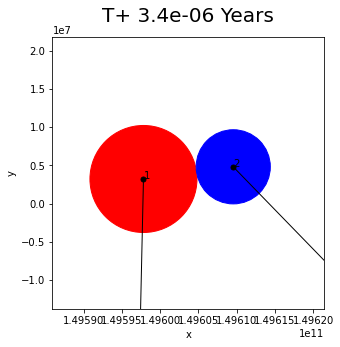

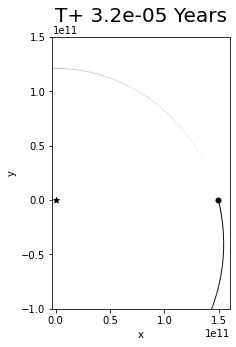

In [94]:
sim, ps = setupSimulation()
sim.collision = "direct"
sim.collision_resolve = my_merge # user defined collision resolution function
rebound.OrbitPlot(sim, lw = 1, xlim = (-3e9, 1.6e11), ylim = (-1.e11, 1.5e11))
plt.title('T + 0 years', fontsize = 20)
circle1 = plt.Circle((ps[1].x, ps[1].y), ps[1].r, color='r')
circle2 = plt.Circle((ps[2].x, ps[2].y), ps[2].r, color='blue')
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
print("System Mass: {}".format([p.m for p in sim.particles]))
sim.integrate(tmax)
print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
print("System Mass: {}".format([p.m for p in sim.particles]))
rebound.OrbitPlot(sim, lw = 1, xlim = (-3e9, 1.6e11), ylim = (-1.e11, 1.5e11))
plt.title('T+ {:.2} Years'.format(sim.t/3600/24/365.24), fontsize = 20, pad=15)

In [95]:
xyz1 = ps[1].xyz
vxyz1 = ps[1].vxyz

In [96]:
def p2b(p):
    return collresolve.Body(p.m, p.r, p.x, p.y, p.z, p.vx, p.vy, p.vz)

def b2p(b):
    m = b.mass
    r = b.radius
    x = b.pos_x
    y = b.pos_y
    z = b.pos_z
    vx = b.vel_x
    vy = b.vel_y
    vz = b.vel_z
    return rebound.particle.Particle(m=m, x=x, y=y, z=z, vx=vx, vy=vy, vz=vz, r=r)


In [97]:
swap = 1
m = 0
0 if m > 0 else (1 if swap else 2)

1

In [98]:
def coll_resolve_merge(sim_pointer, collided_particles_index):

    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.    
    j = collided_particles_index.p2 

    swap = False
    if ps[i].m < ps[j].m:
        i = collided_particles_index.p2
        j = collided_particles_index.p1
        swap = True

    # This part is exciting! We can execute additional code during collisions now!
    cx = (ps[i].x + ps[j].x)/2
    cy = (ps[i].y + ps[j].y)/2
    cr = (ps[i].r + ps[j].r)/2
    xlim = (cx-3*cr, cx+3*cr)
    ylim = (cy-3*cr, cy+3*cr)
    rebound.OrbitPlot(sim)
    plt.title('T+ {:.2} Years'.format(sim.t/3600/24/365.24), fontsize = 20, pad=15)
    fig, ax = rebound.OrbitPlot(sim, xlim = xlim, ylim = ylim)
    circle1 = plt.Circle((ps[i].x, ps[i].y), ps[i].r, color='r')
    circle2 = plt.Circle((ps[j].x, ps[j].y), ps[j].r, color='blue')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.set_title("Merging particle {} into {}".format(j, i))
    ax.text(ps[1].x, ps[1].y, "1"); 
    ax.text(ps[2].x, ps[2].y, "2")
    plt.title('T+ {:.2} Years'.format(sim.t/3600/24/365.24), fontsize = 20, pad=15)
    # plt.savefig("temp.png")
    # writer.append_data(imageio.imread('temp.png'))
    # So we plot the scenario exactly at the timestep that the collision function is triggered

    big = p2b(ps[i])
    small = p2b(ps[j])
    conf = collresolve.Conf()
    collresolve.conf_unit_si(conf)
    # model = collresolve.MODEL_PERFECT_MERGE
    model = collresolve.MODEL_C2019
    collresolve.conf_model(conf, model)
    # imp_vel = collresolve.impact_velocity(conf, big, small)
    # imp_ang = collresolve.impact_angle(conf, big, small)
    # collresolve.setup(conf, big, small, imp_vel, imp_ang)
    print( "impact velocity = {0:.1f} m/s".format( collresolve.impact_velocity( conf, big, small ) ) )
    print( "velocity ratio = {0:.2f}".format( collresolve.impact_velocity( conf, big, small ) / collresolve.escape_velocity( conf, big, small ) ) )
    print( "impact angle = {0:.1f} deg".format( math.degrees( collresolve.impact_angle( conf, big, small ) ) ) )
    res, regime = collresolve.resolve( conf, big, small, 2, 1 )

    print(res)

    ps[i] = b2p(res[0])
    ps[j] = b2p(res[1])

    return 0 if ps[j].m > 0 else (1 if swap else 2)


Particles in the simulation at t=   0.0: 3
System Mass: [1.9884754159665356e+30, 5.965426247899606e+23, 1.9884754159665355e+23]
impact velocity = 29830.1 m/s
velocity ratio = 9.97
impact angle = 9.4 deg
[collresolve.Body(mass=-7.605318815992712e+21, radius=-836520.0248816682, pos_x=149600746662.0666, pos_y=3614539.628854781, pos_z=0.0, vel_x=-7446.847567017373, vel_y=30008.06501137904, vel_z=0.0), collresolve.Body(mass=0.0, radius=0.0, pos_x=0.0, pos_y=0.0, pos_z=0.0, vel_x=0.0, vel_y=0.0, vel_z=0.0), collresolve.Body(mass=8.029954852026069e+23, radius=0.0, pos_x=0.0, pos_y=0.0, pos_z=0.0, vel_x=0.0, vel_y=0.0, vel_z=0.0)]
Particles in the simulation at t=1000.0: 2
System Mass: [1.9884754159665356e+30, -7.605318815992712e+21]


Text(0.5, 1.0, 'T+ 3.2e-05 Years')

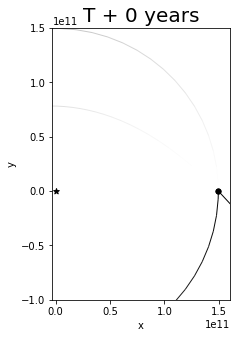

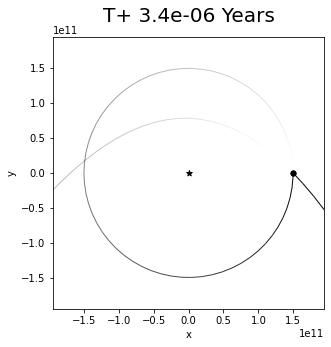

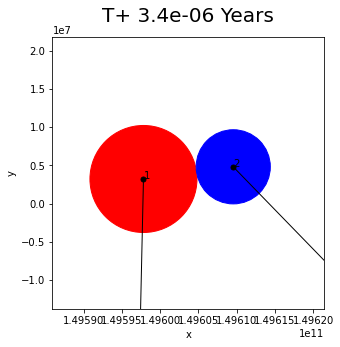

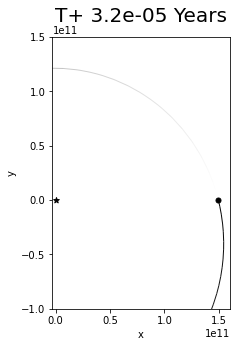

In [99]:
sim, ps = setupSimulation()
sim.collision = "direct"
sim.collision_resolve = coll_resolve_merge # user defined collision resolution function
rebound.OrbitPlot(sim, lw = 1, xlim = (-3e9, 1.6e11), ylim = (-1.e11, 1.5e11))
plt.title('T + 0 years', fontsize = 20)
circle1 = plt.Circle((ps[1].x, ps[1].y), ps[1].r, color='r')
circle2 = plt.Circle((ps[2].x, ps[2].y), ps[2].r, color='blue')
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
print("System Mass: {}".format([p.m for p in sim.particles]))
sim.integrate(tmax)
print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
print("System Mass: {}".format([p.m for p in sim.particles]))
rebound.OrbitPlot(sim, lw = 1, xlim = (-3e9, 1.6e11), ylim = (-1.e11, 1.5e11))
plt.title('T+ {:.2} Years'.format(sim.t/3600/24/365.24), fontsize = 20, pad=15)

In [38]:
xyz2 = ps[1].xyz
vxyz2 = ps[1].vxyz

In [39]:
np.array(xyz1) - np.array(xyz2), np.array(vxyz1) -  np.array(vxyz2)

(array([-1384628.67810059,  2172390.07351443,        0.        ]),
 array([-10322.80092617,   -881.05731042,      0.        ]))

In [40]:
def coll_resolve_merge_movie(sim_pointer, collided_particles_index):

    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.    
    j = collided_particles_index.p2 

    swap = False
    if ps[i].m < ps[j].m:
        i = collided_particles_index.p2
        j = collided_particles_index.p1
        swap = True

    # This part is exciting! We can execute additional code during collisions now!
    cx = (ps[i].x + ps[j].x)/2
    cy = (ps[i].y + ps[j].y)/2
    cr = (ps[i].r + ps[j].r)/2
    xlim = (cx-3*cr, cx+3*cr)
    ylim = (cy-3*cr, cy+3*cr)
    # rebound.OrbitPlot(sim)
    # plt.title('T+ {:.2} Years'.format(sim.t/3600/24/365.24), fontsize = 20, pad=15)
    fig, ax = rebound.OrbitPlot(sim, xlim = xlim, ylim = ylim)
    circle1 = plt.Circle((ps[i].x, ps[i].y), ps[i].r, color='r')
    circle2 = plt.Circle((ps[j].x, ps[j].y), ps[j].r, color='blue')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.set_title("Merging particle {} into {}".format(j, i))
    ax.text(ps[1].x, ps[1].y, "1"); 
    ax.text(ps[2].x, ps[2].y, "2")
    plt.title('T+ {:.2f} s'.format(sim.t), fontsize = 20, pad=15)
    plt.savefig("temp.png")
    writer.append_data(imageio.imread('temp.png'))
    plt.close()
    # So we plot the scenario exactly at the timestep that the collision function is triggered

    big = p2b(ps[i])
    small = p2b(ps[j])
    conf = collresolve.Conf()
    collresolve.conf_unit_si(conf)
    # model = collresolve.MODEL_PERFECT_MERGE
    model = collresolve.MODEL_C2019
    collresolve.conf_model(conf, model)
    # imp_vel = collresolve.impact_velocity(conf, big, small)
    # imp_ang = collresolve.impact_angle(conf, big, small)
    # collresolve.setup(conf, big, small, imp_vel, imp_ang)
    print( "impact velocity = {0:.1f} m/s".format( collresolve.impact_velocity( conf, big, small ) ) )
    print( "velocity ratio = {0:.2f}".format( collresolve.impact_velocity( conf, big, small ) / collresolve.escape_velocity( conf, big, small ) ) )
    print( "impact angle = {0:.1f} deg".format( math.degrees( collresolve.impact_angle( conf, big, small ) ) ) )
    res, regime = collresolve.resolve( conf, big, small, 2, 1 )

    print(res)

    ps[i] = b2p(res[0])
    ps[j] = b2p(res[1])

    cx = (ps[i].x + ps[j].x)/2
    cy = (ps[i].y + ps[j].y)/2
    cr = (ps[i].r + ps[j].r)/2
    xlim = (cx-3*cr, cx+3*cr)
    ylim = (cy-3*cr, cy+3*cr)
    fig, ax = rebound.OrbitPlot(sim, xlim = xlim, ylim = ylim)
    circle1 = plt.Circle((ps[i].x, ps[i].y), ps[i].r, color='r')
    circle2 = plt.Circle((ps[j].x, ps[j].y), ps[j].r, color='blue')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.set_title("Merging particle {} into {}".format(j, i))
    ax.text(ps[1].x, ps[1].y, "1"); 
    ax.text(ps[2].x, ps[2].y, "2")
    plt.title('T+ {:.2f} s'.format(sim.t), fontsize = 20, pad=15)
    plt.savefig("temp.png")
    writer.append_data(imageio.imread('temp.png'))
    plt.close()

    return 0 if ps[j].m > 0 else (1 if swap else 2)


In [41]:
import imageio
gif_file_name = "hitNrun.gif"
with imageio.get_writer(gif_file_name, mode="I") as writer:
    sim, ps = setupSimulation()
    sim.collision = "direct"
    sim.collision_resolve = coll_resolve_merge_movie # user defined collision resolution function
    for t in np.linspace(0, tmax, tmax*2):
        sim.integrate(t)
        if t>750:
            print("Particles in the simulation at t=%6.1f: %d"%(sim.t,sim.N))
            print("Masses: {}, Total: {}".format([p.m for p in sim.particles], sum([p.m for p in sim.particles])))
            cx = (ps[1].x + ps[2].x)/2
            cy = (ps[1].y + ps[2].y)/2
            cr = (ps[1].r + ps[2].r)/2
            d = np.linalg.norm((ps[1] - ps[2]).xyz)
            xlim = (cx-3*cr, cx+3*cr) if 3*cr > 1.1*d/2 else (cx-1.1*d/2, cx+1.1*d/2)
            ylim = (cy-3*cr, cy+3*cr) if 3*cr > 1.1*d/2 else (cy-1.1*d/2, cy+1.1*d/2)
            rebound.OrbitPlot(sim, lw = 1, xlim = xlim, ylim = ylim)
            plt.title('T+ {:.2f} s'.format(sim.t), fontsize = 20, pad=15)
            circle1 = plt.Circle((ps[1].x, ps[1].y), ps[1].r, color='r')
            circle2 = plt.Circle((ps[2].x, ps[2].y), ps[2].r, color='blue')
            plt.gca().add_patch(circle1)
            plt.gca().add_patch(circle2)
            plt.savefig("temp.png")
            writer.append_data(imageio.imread('temp.png'))
            plt.close()
            

Particles in the simulation at t= 750.4: 3
Masses: [1.9884754159665356e+30, 9.942377079832678e+25, 1.988475415966536e+25], Total: 1.9885947244914936e+30
Particles in the simulation at t= 750.9: 3
Masses: [1.9884754159665356e+30, 9.942377079832678e+25, 1.988475415966536e+25], Total: 1.9885947244914936e+30
Particles in the simulation at t= 751.4: 3
Masses: [1.9884754159665356e+30, 9.942377079832678e+25, 1.988475415966536e+25], Total: 1.9885947244914936e+30
Particles in the simulation at t= 751.9: 3
Masses: [1.9884754159665356e+30, 9.942377079832678e+25, 1.988475415966536e+25], Total: 1.9885947244914936e+30
Particles in the simulation at t= 752.4: 3
Masses: [1.9884754159665356e+30, 9.942377079832678e+25, 1.988475415966536e+25], Total: 1.9885947244914936e+30
Particles in the simulation at t= 752.9: 3
Masses: [1.9884754159665356e+30, 9.942377079832678e+25, 1.988475415966536e+25], Total: 1.9885947244914936e+30
Particles in the simulation at t= 753.4: 3
Masses: [1.9884754159665356e+30, 9.9423